In [1]:
import os

In [2]:
Datasets = os.path.dirname(os.getcwd()) + "\\Data\\"
__depends__ = [Datasets+"RetailMarketOrder.sas7bdat", 
               Datasets+"InstitutionOrder.sas7bdat", 
               Datasets+"FutureReturn.sas7bdat"]
__dest__ = []

In [3]:
__depends__

['G:\\.shortcut-targets-by-id\\1CEORRTyvlaWjSS1ycXHr3bLmY4L1xR1S\\Imitating Human Trades\\Data\\RetailMarketOrder.sas7bdat',
 'G:\\.shortcut-targets-by-id\\1CEORRTyvlaWjSS1ycXHr3bLmY4L1xR1S\\Imitating Human Trades\\Data\\InstitutionOrder.sas7bdat',
 'G:\\.shortcut-targets-by-id\\1CEORRTyvlaWjSS1ycXHr3bLmY4L1xR1S\\Imitating Human Trades\\Data\\FutureReturn.sas7bdat']

In [4]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib import ticker
%pylab inline
pylab.rcParams['figure.figsize'] = (20,10)
import seaborn as sns; sns.set()
from pandas.tseries.offsets import *
from dateutil.relativedelta import *
import datetime as dt
import os
from linearmodels.asset_pricing import TradedFactorModel, LinearFactorModel
from IPython.core.pylabtools import figsize
from IPython.core.interactiveshell import InteractiveShell
from fredapi import Fred
fred = Fred(api_key = 'b0363f9c9d853b92b27e06c4727bc2ea')
import pandas_datareader.data as web
# from pandas_to_latex import pandas_to_latex, results_to_latex

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('mode.use_inf_as_na', True)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 500)
idx = pd.IndexSlice
import warnings
warnings.filterwarnings('ignore')

In [6]:
def wavg(group, var, weight):
    group = group[[var,weight]].dropna()
    d = group[var]
    w = group[weight]
    try:
        return (d * w).sum() / w.sum() 
    except ZeroDivisionError:
        return np.nan

In [7]:
retail = pd.read_sas(__depends__[0], encoding = 'latin-1')
retail.columns = retail.columns.str.lower()
retail[['permno','russellgroup']] = retail[['permno','russellgroup']].astype(int)
retail.tail()

,permno,ticker,companyname,date,russellgroup,sector,price,marketcap,moribvol
14431820,93436,TSLA,TESLA INC,2021-12-27,1,XLY,"1,093.940","1,098,605.595",0.001
14431821,93436,TSLA,TESLA INC,2021-12-28,1,XLY,"1,088.470","1,093,112.295",-0.021
14431822,93436,TSLA,TESLA INC,2021-12-29,1,XLY,"1,086.190","1,090,822.542",-0.033
14431823,93436,TSLA,TESLA INC,2021-12-30,1,XLY,"1,070.340","1,074,904.966",-0.007
14431824,93436,TSLA,TESLA INC,2021-12-31,1,XLY,"1,056.780","1,092,190.615",-0.087


- permno is the permanent stock identifier used in CRSP
- Retail Market Order Imbalance (moribvol) = (Shares Purchased - Shares Sold)/(Shares Purchased+Shares Sold)
    - We standardize by dividing the sum of total buy and sell retail market orders to make this variable comparable across different stocks
    - Tracking Retail Investor Activity: https://onlinelibrary.wiley.com/doi/abs/10.1111/jofi.13033
- 5 Russell groups
    - Classification of stocks according to the constituent members of Russell indices
    - Large-Cap (russellgroup = 1): stocks in Russell Top 200, which consists of the largest 200 members in Russell 1000
    - Mid-Cap (russellgroup = 2): stocks in Russell Mid-Cap, which consists of the smallest 800 members in Russell 1000
    - Small-Cap (russellgroup = 3): the largest 1000 members in Russell 2000
    - Micro-Cap (russellgroup = 4): stocks in Russell Micro-Cap, which consists of the smallest 1000 members in Russell 2000 plus the largest 1000 stocks outside Russell 2000
    - Nano-Cap (russellgroup = 5): all remaining stocks
- 11 sectors
    - The Global Industry Classification Standard (GICS)
    - I name a sector using the corresponding ticker of the SPDR sector ETF (see, https://www.sectorspdr.com/sectorspdr/)

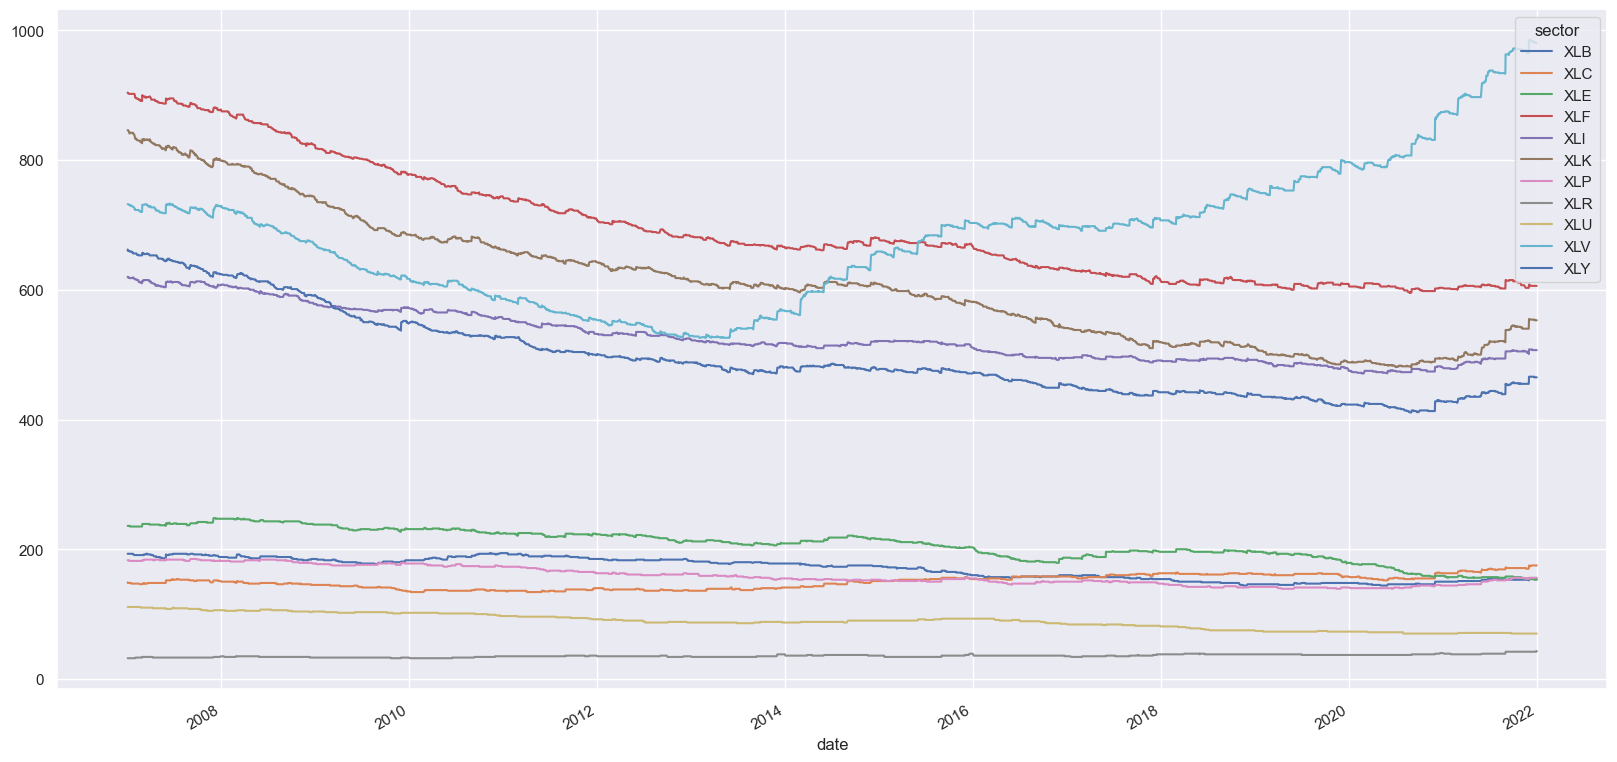

In [8]:
retail.groupby(['date','sector'])['permno'].count().unstack().plot();

In [9]:
institution = pd.read_sas(__depends__[1], encoding = 'latin-1')
institution.columns = institution.columns.str.lower()
institution[['permno','russellgroup']] = institution[['permno','russellgroup']].astype(int)
institution.tail()

,permno,ticker,companyname,date,russellgroup,sector,price,marketcap,iibvol
10772976,93436,TSLA,TESLA MOTORS INC,2011-03-25,2,XLY,22.750,"2,168.871",0.000
10772977,93436,TSLA,TESLA MOTORS INC,2011-03-28,2,XLY,23.250,"2,216.539",1.000
10772978,93436,TSLA,TESLA MOTORS INC,2011-03-29,2,XLY,23.920,"2,280.413",0.000
10772979,93436,TSLA,TESLA MOTORS INC,2011-03-30,2,XLY,23.710,"2,260.393",0.000
10772980,93436,TSLA,TESLA MOTORS INC,2011-03-31,2,XLY,27.750,"2,651.651",-1.000


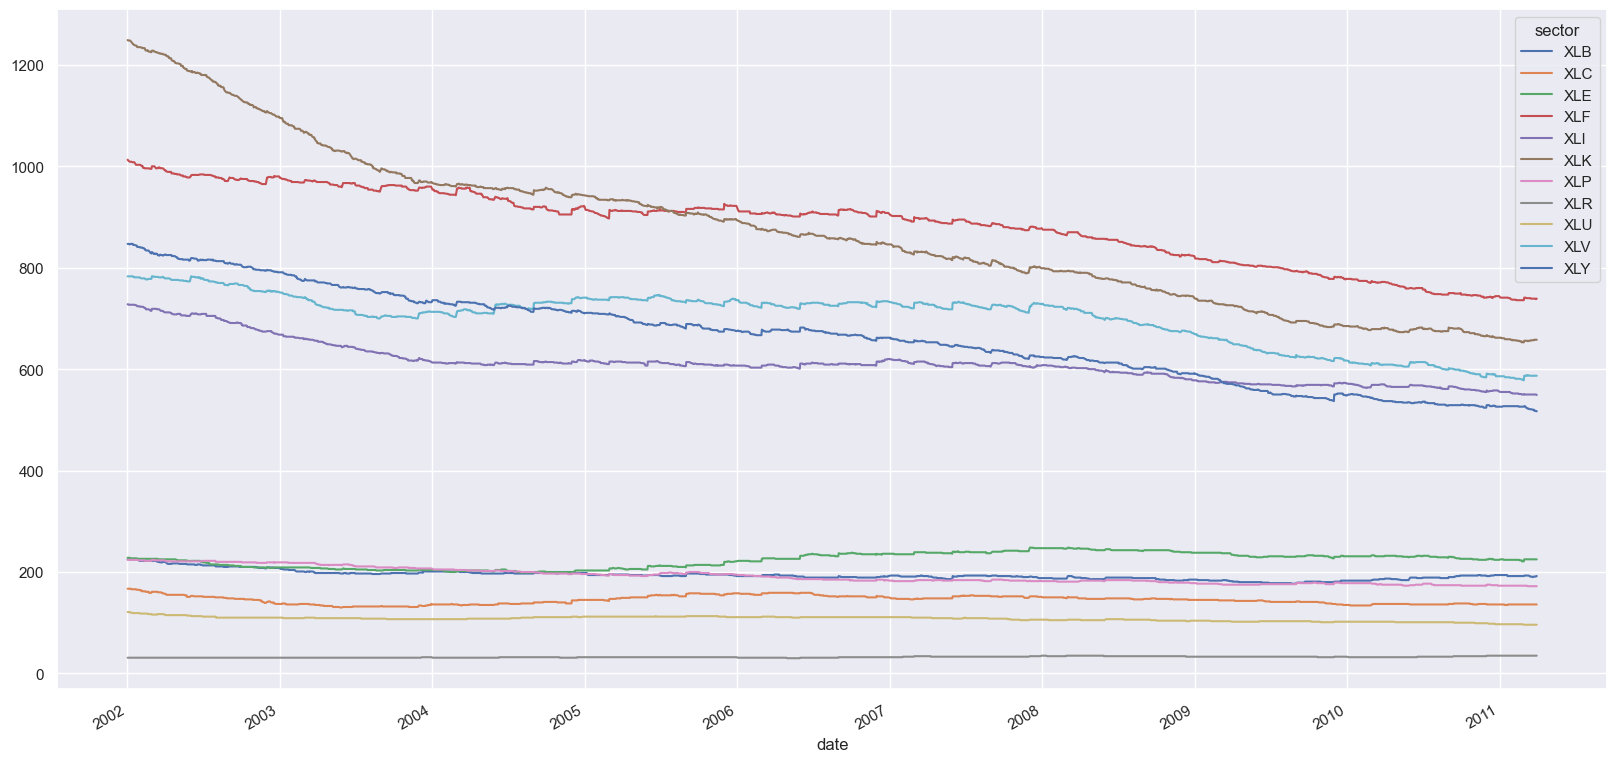

In [10]:
institution.groupby(['date','sector'])['permno'].count().unstack().plot();

In [ ]:
ret = pd.read_sas(__depends__[2], encoding = 'latin-1')
ret.columns = ret.columns.str.lower()
ret['permno'] = ret['permno'].astype(int)
ret.tail()

,permno,date,ret_1,ret_5,ret_10,ret_20
21466675,93436,2021-12-27,-0.005,0.097,-0.033,-0.160
21466676,93436,2021-12-28,-0.002,0.056,-0.022,-0.139
21466677,93436,2021-12-29,-0.015,0.002,0.018,-0.237
21466678,93436,2021-12-30,-0.013,-0.005,-0.036,-0.209
21466679,93436,2021-12-31,0.135,-0.028,-0.007,-0.114


- ret_i, i = 1,5,10,20, is the return over next day, 5 days, 10 days, 20 days
    - I already moved the return backward for one trading day to avoid potentisl forward-looking bias. For example, -0.003 ret_1 of stock 93436 at 2022-06-24 is the return earned by this stock at 2022-06-27

In [ ]:
ptflist = ['Low','2','3','4','5','6','7','8','9','High','H-L']
stock_grp = ['Large-Cap','Mid-Cap','Small-Cap','Micro-Cap','Nano-Cap']
results = pd.DataFrame([], columns = stock_grp, 
                       index = ['Low','','2','','3','','4','','5','','6','','7','','8','','9','','High','','H-L',''])
results.index.name = 'Retail Market Order Imbalance'

fut_ret = 'ret_5'
for i in np.arange(5):
    stock_grp[i]
    df_ = pd.merge(retail[retail['russellgroup'] == (i+1)][['permno','date','moribvol']], 
                   ret, on = ['permno','date'], how = 'inner')
    breakpoints = df_.groupby('date')['moribvol'].describe(percentiles = [.1,.2,.3,.4,.5,.6,.7,.8,.9])
    df_ = pd.merge(df_, breakpoints, on = 'date', how = 'left')
     
    def group(row, signal = 'moribvol'):
        if row[signal] < row['10%']:
            value = 'Low'
        elif row[signal] < row['20%']:
            value = '2'
        elif row[signal] < row['30%']:
            value = '3'
        elif row[signal] < row['40%']:
            value = '4'
        elif row[signal] < row['50%']:
            value = '5'
        elif row[signal] < row['60%']:
            value = '6'
        elif row[signal] < row['70%']:
            value = '7'
        elif row[signal] < row['80%']:
            value = '8'
        elif row[signal] < row['90%']:
            value = '9'
        elif row[signal] >= row['90%']:
            value = 'High'
        else:
            value = np.nan
        return value
        
    df_['rank'] = df_.apply(group, axis = 1) 
    ptf = df_.groupby(['date','rank'])[fut_ret].mean().unstack().dropna()
    ptf['H-L'] = ptf['High']-ptf['Low']
    ptf['const'] = 1
    for j in np.arange(11):
        res = sm.OLS(ptf[ptflist[j]], ptf['const'], missing = 'drop').fit(cov_type = 'HAC', cov_kwds = {'maxlags':1})
        results.iloc[2*j,i] = 252*res.params[0]
        results.iloc[2*j+1,i] = res.tvalues[0]
    
results

'Large-Cap'

'Mid-Cap'

'Small-Cap'

'Micro-Cap'

'Nano-Cap'

,Large-Cap,Mid-Cap,Small-Cap,Micro-Cap,Nano-Cap
Retail Market Order Imbalance,,,,,
Low,0.595,0.585,1.051,0.585,0.674
,4.151,3.530,6.204,3.639,2.684
2,0.620,0.601,1.105,0.508,0.569
,4.189,3.518,6.082,2.470,1.584
3,0.553,0.691,1.152,0.486,0.505
,3.782,3.916,6.143,2.141,1.220
4,0.607,0.679,1.236,0.467,-0.048
,4.003,3.737,6.343,1.957,-0.110
5,0.581,0.670,1.331,0.517,-1.282


In [ ]:
ptflist = ['Low','2','3','4','5','6','7','8','9','High','H-L']
stock_grp = ['XLU','XLF','XLB','XLP','XLY','XLK','XLV','XLI','XLE','XLC','XLR']
results = pd.DataFrame([], columns = stock_grp, 
                       index = ['Low','','2','','3','','4','','5','','6','','7','','8','','9','','High','','H-L',''])
results.index.name = 'Retail Market Order Imbalance'

fut_ret = 'ret_5'
for i in np.arange(11):
    stock_grp[i]
    df_ = pd.merge(retail[retail['sector'] == stock_grp[i]][['permno','date','moribvol']], 
                   ret, on = ['permno','date'], how = 'inner')
    breakpoints = df_.groupby('date')['moribvol'].describe(percentiles = [.1,.2,.3,.4,.5,.6,.7,.8,.9])
    df_ = pd.merge(df_, breakpoints, on = 'date', how = 'left')
     
    def group(row, signal = 'moribvol'):
        if row[signal] < row['10%']:
            value = 'Low'
        elif row[signal] < row['20%']:
            value = '2'
        elif row[signal] < row['30%']:
            value = '3'
        elif row[signal] < row['40%']:
            value = '4'
        elif row[signal] < row['50%']:
            value = '5'
        elif row[signal] < row['60%']:
            value = '6'
        elif row[signal] < row['70%']:
            value = '7'
        elif row[signal] < row['80%']:
            value = '8'
        elif row[signal] < row['90%']:
            value = '9'
        elif row[signal] >= row['90%']:
            value = 'High'
        else:
            value = np.nan
        return value
        
    df_['rank'] = df_.apply(group, axis = 1) 
    ptf = df_.groupby(['date','rank'])[fut_ret].mean().unstack().dropna()
    ptf['H-L'] = ptf['High']-ptf['Low']
    ptf['const'] = 1
    for j in np.arange(11):
        res = sm.OLS(ptf[ptflist[j]], ptf['const'], missing = 'drop').fit(cov_type = 'HAC', cov_kwds = {'maxlags':1})
        results.iloc[2*j,i] = 252*res.params[0]
        results.iloc[2*j+1,i] = res.tvalues[0]
    
results

'XLU'

'XLF'

'XLB'

'XLP'

'XLY'

'XLK'

'XLV'

'XLI'

'XLE'

'XLC'

'XLR'

,XLU,XLF,XLB,XLP,XLY,XLK,XLV,XLI,XLE,XLC,XLR
Retail Market Order Imbalance,,,,,,,,,,,
Low,0.467,0.694,0.326,0.323,0.501,0.603,0.586,0.567,-0.225,0.397,0.747
,3.252,3.701,1.558,2.175,2.592,3.633,3.093,3.211,-0.765,1.354,1.966
2,0.599,0.620,0.467,0.612,0.581,0.716,0.647,0.651,0.045,0.688,0.472
,4.243,2.564,2.067,3.703,2.551,3.760,3.046,3.219,0.133,2.084,1.114
3,0.460,0.646,0.622,0.652,0.766,0.687,0.623,0.608,0.222,0.490,0.400
,3.352,2.514,2.682,4.388,3.288,3.499,2.921,2.921,0.616,1.635,0.893
4,0.535,0.630,0.633,0.698,0.734,0.837,0.695,0.714,0.207,0.679,0.753
,3.741,2.449,2.629,4.667,3.122,4.125,3.273,3.395,0.598,2.133,1.360
5,0.428,0.645,0.763,0.674,0.693,0.829,0.630,0.676,0.169,0.506,0.236


In [ ]:
ptflist = ['Low','2','3','4','5','6','7','8','9','High','H-L']
stock_grp = ['Large-Cap','Mid-Cap','Small-Cap']
results = pd.DataFrame([], columns = stock_grp, 
                       index = ['Low','','2','','3','','4','','5','','6','','7','','8','','9','','High','','H-L',''])
results.index.name = 'Institution Order Imbalance'

fut_ret = 'ret_1'
for i in np.arange(3):
    stock_grp[i]
    df_ = pd.merge(institution[institution['russellgroup'] == (i+1)][['permno','date','iibvol']], 
                   ret, on = ['permno','date'], how = 'inner')
    breakpoints = df_.groupby('date')['iibvol'].describe(percentiles = [.1,.2,.3,.4,.5,.6,.7,.8,.9])
    df_ = pd.merge(df_, breakpoints, on = 'date', how = 'left')
     
    def group(row, signal = 'iibvol'):
        if row[signal] < row['10%']:
            value = 'Low'
        elif row[signal] < row['20%']:
            value = '2'
        elif row[signal] < row['30%']:
            value = '3'
        elif row[signal] < row['40%']:
            value = '4'
        elif row[signal] < row['50%']:
            value = '5'
        elif row[signal] < row['60%']:
            value = '6'
        elif row[signal] < row['70%']:
            value = '7'
        elif row[signal] < row['80%']:
            value = '8'
        elif row[signal] < row['90%']:
            value = '9'
        elif row[signal] >= row['90%']:
            value = 'High'
        else:
            value = np.nan
        return value
        
    df_['rank'] = df_.apply(group, axis = 1) 
    ptf = df_.groupby(['date','rank'])[fut_ret].mean().unstack().dropna()
    ptf['H-L'] = ptf['High']-ptf['Low']
    ptf['const'] = 1
    for j in np.arange(11):
        res = sm.OLS(ptf[ptflist[j]], ptf['const'], missing = 'drop').fit(cov_type = 'HAC', cov_kwds = {'maxlags':1})
        results.iloc[2*j,i] = 252*res.params[0]
        results.iloc[2*j+1,i] = res.tvalues[0]
    
results

'Large-Cap'

'Mid-Cap'

'Small-Cap'

,Large-Cap,Mid-Cap,Small-Cap
Institution Order Imbalance,,,
Low,0.042,0.060,-0.413
,0.434,0.178,-0.280
2,0.009,0.032,-0.200
,0.098,0.099,-0.141
3,0.040,-0.021,-0.806
,0.457,-0.067,-0.481
4,0.084,0.103,-0.229
,0.979,0.329,-0.185
5,0.107,0.160,-0.381


# Stock Selection

- Large Cap Tech (XLK) firms
- All stocks listed

In [ ]:
# !pip install swig
# !pip install box2d-py
# !pip install wrds
# !pip install yfinance

import pytz
from datetime import datetime as dt
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

In [ ]:
# stock_grp = ['Large-Cap','Mid-Cap','Small-Cap','Micro-Cap','Nano-Cap']
retail_tech_largeCap = retail[(retail["sector"] == 'XLK') & (retail["russellgroup"] == 1)]
retail_tech_largeCap_ret = pd.merge(retail_tech_largeCap[['ticker','permno','date','moribvol']], ret, on = ['permno','date'], how = 'inner')
retail_tech_largeCap_ret

,ticker,permno,date,moribvol,ret_1,ret_5,ret_10,ret_20
0,SUNW,10078,2007-01-03,-0.161,0.027,0.083,0.045,0.182
1,SUNW,10078,2007-01-04,0.236,-0.016,0.079,0.014,0.165
2,SUNW,10078,2007-01-05,0.254,0.009,0.082,0.027,0.186
3,SUNW,10078,2007-01-08,-0.294,0.014,0.073,0.002,0.156
4,SUNW,10078,2007-01-09,0.762,0.047,0.045,0.073,0.150
...,...,...,...,...,...,...,...,...
88785,AOL,93091,2010-05-24,-0.040,-0.025,-0.033,-0.041,0.082
88786,AOL,93091,2010-05-25,0.038,0.002,0.015,-0.023,0.095
88787,AOL,93091,2010-05-26,-0.280,0.021,0.014,0.019,0.049
88788,AOL,93091,2010-05-27,0.159,-0.025,0.006,-0.008,0.038


In [ ]:
retail_tech_largeCap_ret['ticker'].unique()

array(['SUNW', 'JAVA', 'ORCL', 'MSFT', 'EMC', 'FISV', 'DELL', 'MMI',
       'IBM', 'NOW', 'WDAY', 'AAPL', 'AMAT', 'CDK', 'PYPL', 'TXN', 'HPE',
       'SQ', 'VSM', 'ZM', 'GLW', 'MOT', 'MSI', 'HPQ', 'DXC', 'ADP',
       'LRCX', 'MU', 'INTC', 'ADI', 'AMD', 'ADBE', 'SYMC', 'CSCO', 'QCOM',
       'FDC', 'INTU', 'NTAP', 'ADSK', 'BRCM', 'CTSH', 'NVDA', 'JNPR',
       'GPN', 'FIS', 'CRM', 'MA', 'WU', 'FSLR', 'VMW', 'V', 'AVGO', 'AOL'],
      dtype=object)

In [ ]:
fut_ret = 'ret_5'
grouped = retail_tech_largeCap_ret.groupby('permno')

tech_largeCap_correlation = grouped.apply(lambda x: x['moribvol'].corr(x[fut_ret])).dropna()
tech_largeCap_correlation = tech_largeCap_correlation.sort_values(ascending=False).reset_index()
tech_largeCap_correlation = tech_largeCap_correlation.rename(columns={tech_largeCap_correlation.columns[-1]: 'corr'})

tech_largeCap_correlation = tech_largeCap_correlation.merge(retail_tech_largeCap_ret[['ticker', 'permno']], on='permno')
tech_largeCap_correlation = tech_largeCap_correlation.drop_duplicates()
tech_largeCap_correlation

,permno,corr,ticker
0,14926,0.256,CDK
124,40125,0.105,DXC
165,18484,0.082,ZM
567,77546,0.073,FDC
735,77178,0.055,QCOM
4512,85631,0.052,ADSK
5145,91611,0.051,FSLR
5648,10078,0.045,SUNW
5811,10078,0.045,JAVA
6003,10107,0.044,MSFT


In [ ]:
# all data points 
retail_ret = pd.merge(retail[['ticker','permno','date','moribvol', "russellgroup", "sector"]], ret, on = ['permno','date'], how = 'inner')
retail_ret

,ticker,permno,date,moribvol,russellgroup,sector,ret_1,ret_5,ret_10,ret_20
0,EWST,10001,2007-01-03,-1.000,5,XLU,0.023,-0.000,0.035,0.027
1,EWST,10001,2007-01-04,0.000,5,XLU,-0.010,0.008,-0.018,-0.014
2,EWST,10001,2007-01-05,0.000,5,XLU,0.008,0.010,-0.004,0.019
3,EWST,10001,2007-01-08,0.000,5,XLU,-0.009,-0.002,0.010,0.004
4,EWST,10001,2007-01-09,1.000,5,XLU,-0.012,0.019,0.019,0.014
...,...,...,...,...,...,...,...,...,...,...
14431820,TSLA,93436,2021-12-27,0.001,1,XLY,-0.005,0.097,-0.033,-0.160
14431821,TSLA,93436,2021-12-28,-0.021,1,XLY,-0.002,0.056,-0.022,-0.139
14431822,TSLA,93436,2021-12-29,-0.033,1,XLY,-0.015,0.002,0.018,-0.237
14431823,TSLA,93436,2021-12-30,-0.007,1,XLY,-0.013,-0.005,-0.036,-0.209


In [ ]:
fut_ret = 'ret_5'
grouped = retail_ret.groupby(['permno', 'ticker', "russellgroup", "sector"]) # tickers are not unique identifer
df_correlation = grouped.apply(lambda x: x['moribvol'].corr(x[fut_ret])).dropna()
df_correlation = df_correlation[df_correlation > 0].reset_index()
df_correlation = df_correlation.rename(columns={df_correlation.columns[-1]: 'corr'})

In [ ]:
df_correlation.groupby(['russellgroup','sector'])['permno'].count().unstack().plot.bar();

In [ ]:
# Group the data by Group1 and Group2
grouped = df_correlation.groupby(['sector'])

# Plot the distribution of Value for each group
grouped['corr'].plot.hist(alpha=0.5, bins=20)

plt.legend()
plt.show()

sector
XLB    AxesSubplot(0.125,0.11;0.775x0.77)
XLC    AxesSubplot(0.125,0.11;0.775x0.77)
XLE    AxesSubplot(0.125,0.11;0.775x0.77)
XLF    AxesSubplot(0.125,0.11;0.775x0.77)
XLI    AxesSubplot(0.125,0.11;0.775x0.77)
XLK    AxesSubplot(0.125,0.11;0.775x0.77)
XLP    AxesSubplot(0.125,0.11;0.775x0.77)
XLR    AxesSubplot(0.125,0.11;0.775x0.77)
XLU    AxesSubplot(0.125,0.11;0.775x0.77)
XLV    AxesSubplot(0.125,0.11;0.775x0.77)
XLY    AxesSubplot(0.125,0.11;0.775x0.77)
Name: corr, dtype: object

In [ ]:
# Use seaborn's facetgrid to create a panel of plots
g = sns.FacetGrid(df_correlation, col='russellgroup', row='sector')
g.map(sns.histplot, 'corr', kde=False)

# Show the plot
g.fig.tight_layout()
g.fig.show()

In [ ]:
# Define a custom function to find the row with the maximum value of the 'corr' column
def get_max_row(group):
    return group[group['corr'] == group['corr'].max()].iloc[0, :]

# Group the data by the column 'sector'
grouped = df_correlation.groupby(['russellgroup','sector'])

# Apply the custom function to each group and store the result in a new DataFrame
df_max = grouped.apply(get_max_row)
df_max

permno ticker  russellgroup sector  corr
russellgroup sector                                          
1            XLB      16851   DWDP             1    XLB 0.229
             XLC      91066    VIA             1    XLC 0.121
             XLE      13141    WPX             1    XLE 0.118
             XLF      64565    CFC             1    XLF 0.134
             XLI      11955    WMI             1    XLI 0.162
             XLK      14926    CDK             1    XLK 0.256
             XLP      18163     PG             1    XLP 0.073
             XLR      91388      H             1    XLR 0.140
             XLU      24563    TXU             1    XLU 0.142
             XLV      16544   BIVV             1    XLV 0.244
             XLY      66181     HD             1    XLY 0.061
2            XLB      15917    GCP             2    XLB 0.184
             XLC      79903    HHS             2    XLC 0.114
             XLE      90180   ATLS             2    XLE 0.139
             XLF      81593     WM             2    XLF 0.326
             XLI      81285     TT             2    XLI 0.191
             XLK      81705   FEIC             2    XLK 0.267
             XLP      52038    SYY             2    XLP 0.145
             XLR      14252   GLPI             2    XLR 0.304
             XLU      14401    OGS             2    XLU 0.222
             XLV      86923    TRI             2    XLV 0.216
             XLY      18578    KTB             2    XLY 0.375
3            XLB      18075     AP             3    XLB 0.231
             XLC      92265    RCH             3    XLC 0.806
             XLE      90674    AEZ             3    XLE 0.348
             XLF      15180   ICBK             3    XLF 0.666
             XLI      91299    GFN             3    XLI 0.437
             XLK      80236   DSPG             3    XLK 1.000
             XLP      76461   VERU             3    XLP 0.282
             XLR      38746    AXR             3    XLR 0.412
             XLU      91840     RZ             3    XLU 0.276
             XLV      16670   CATS             3    XLV 0.746
             XLY      87379   CLCT             3    XLY 0.790
4            XLB      10881   ANLT             4    XLB 1.000
             XLC      65787    TRB             4    XLC 0.682
             XLE      83991    THX             4    XLE 0.867
             XLF      86300   PCBS             4    XLF 1.000
             XLI      21020    AMR             4    XLI 1.000
             XLK      15797   CSRA             4    XLK 1.000
             XLP      13598   KRFT             4    XLP 1.000
             XLR      91388      H             4    XLR 0.470
             XLU      77495   MWAV             4    XLU 1.000
             XLV      66368    CTT             4    XLV 1.000
             XLY      11873   DISK             4    XLY 1.000
5            XLB      91946    SHJ             5    XLB 0.385
             XLC      17323   LIVX             5    XLC 0.833
             XLE      79393   EWEB             5    XLE 0.871
             XLF      10682   UBMT             5    XLF 0.412
             XLI      18533    RMO             5    XLI 0.607
             XLK      15410   APPF             5    XLK 0.753
             XLP      89447   CVGW             5    XLP 0.234
             XLR      20147   HFEN             5    XLR 0.294
             XLU      84345   USEY             5    XLU 0.150
             XLV      19397    TOI             5    XLV 0.479
             XLY      18936     XL             5    XLY 0.519

In [ ]:
selected_tech = ["DXC", "ZM", "QCOM", "ADSK", "FSLR", "MSFT", "AMD", "ORCL", "VMW", "INTU", 'WU']
retail_tech = retail[retail['ticker'].isin(selected_tech)]
retail_tech = retail_tech.rename(columns={'ticker': 'tic'})

# Earliest date of public trades
min(retail_tech['date'])

# retail_tech['date'] = retail_tech['date'].astype(str)
retail_tech

Timestamp('2007-01-03 00:00:00')

,permno,tic,companyname,date,russellgroup,sector,price,marketcap,moribvol
28532,10104,ORCL,ORACLE CORP,2007-01-03,1,XLK,17.510,"90,740.166",-0.168
28533,10104,ORCL,ORACLE CORP,2007-01-04,1,XLK,17.680,"91,621.138",0.046
28534,10104,ORCL,ORACLE CORP,2007-01-05,1,XLK,17.640,"91,413.846",-0.210
28535,10104,ORCL,ORACLE CORP,2007-01-08,1,XLK,17.860,"92,553.934",-0.142
28536,10104,ORCL,ORACLE CORP,2007-01-09,1,XLK,17.820,"92,346.642",-0.102
...,...,...,...,...,...,...,...,...,...
13682189,92257,VMW,VMWARE INC,2021-12-27,1,XLK,116.280,"48,880.158",0.068
13682190,92257,VMW,VMWARE INC,2021-12-28,1,XLK,117.480,"49,384.599",-0.215
13682191,92257,VMW,VMWARE INC,2021-12-29,1,XLK,117.880,"49,552.743",0.004
13682192,92257,VMW,VMWARE INC,2021-12-30,1,XLK,117.260,"49,292.118",-0.055


In [ ]:
tz = pytz.timezone("America/New_York")
start = tz.localize(dt(2007,1,3))
end = tz.localize(dt.today())

yf_tech = YahooDownloader(start_date = start,
                          end_date = end,
                          ticker_list = selected_tech).fetch_data()

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(yf_tech)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)
processed['date'] = pd.to_datetime(processed['date'])
processed

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (41301, 8)
Successfully added technical indicators
Successfully added turbulence index


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2007-01-03,40.630,41.830,39.810,40.560,3873900,ADSK,2,0.000,42.034,39.856,100.000,66.667,100.000,40.560,40.560,0.000
1,2007-01-03,20.080,20.400,19.350,19.520,28350300,AMD,2,0.000,42.034,39.856,100.000,66.667,100.000,19.520,19.520,0.000
2,2007-01-03,26.406,26.430,25.646,15.895,3087677,DXC,2,0.000,42.034,39.856,100.000,66.667,100.000,15.895,15.895,0.000
3,2007-01-03,30.170,30.290,28.200,28.500,487000,FSLR,2,0.000,42.034,39.856,100.000,66.667,100.000,28.500,28.500,0.000
4,2007-01-03,30.680,31.060,29.100,26.496,4734600,INTU,2,0.000,42.034,39.856,100.000,66.667,100.000,26.496,26.496,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36445,2023-02-02,443.960,457.940,443.390,452.160,1915013,INTU,3,11.213,441.819,364.004,60.110,295.904,49.162,397.391,395.750,29.275
36446,2023-02-02,258.820,264.690,257.250,264.600,39731094,MSFT,3,3.951,259.767,219.662,59.388,285.836,26.190,239.281,241.928,29.275
36447,2023-02-02,90.660,91.220,88.945,89.380,8072123,ORCL,3,1.790,91.378,84.592,61.555,91.161,28.985,85.770,82.740,29.275
36448,2023-02-02,138.460,139.164,134.801,135.850,17102313,QCOM,3,5.287,141.771,108.098,59.169,136.703,45.763,120.061,120.012,29.275


In [ ]:
df_merged = pd.merge(retail_tech, processed, on=['tic', 'date'])
df_merged['tic'].unique()

# ["DXC", "ZM", "QCOM", "ADSK", "FSLR", "MSFT", "AMD", "ORCL", "VMW", "INTU", 'WU']

array(['ORCL', 'MSFT', 'DXC', 'AMD', 'QCOM', 'INTU', 'ADSK', 'WU', 'FSLR'],
      dtype=object)

In [ ]:
# Compare to see if the data lines up
# df_merged.groupby(['date','tic'])['price'].plot()
# plt.legend()
# plt.show()

# df_merged.groupby(['date','sector'])['permno'].count().unstack().plot();
processed[processed['tic'] == "VMW"]

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
